In [19]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, split, regexp_replace, lower
from pyspark import SparkContext
import subprocess
import nltk
from pyspark.ml.feature import StopWordsRemover
# !pip3 install --user wordcloud
from wordcloud import WordCloud
ss = SparkSession.builder.master("local[*]").appName("ddam-8_STEP-2_clean-text").getOrCreate()

import matplotlib.pyplot as plt

# Function definitions

### Split words by spaces

In [26]:
def split_text(df, colname):
    return df.withColumn(colname, split(lower(col(colname)), " ")).dropna()

### Plot most frequent words

In [27]:
def word_probas(df, colname, prior_c=-2):
    rowcount = float(df.select(colname).rdd.flatMap(lambda s: s[0]).count())
    return df.select(colname).rdd.flatMap(lambda s: s[0])\
                                 .map(lambda w: (w, 1))\
                                 .reduceByKey((lambda a, b: a + b))\
                                 .map(lambda e: (e[0], max(0., e[1] + prior_c) / max(1., rowcount + prior_c)))

    return wc
def plot_most_probable(df, colname, prior=None, n=20, title='', prior_c=-10,rot = 45):
    bars = word_probas(df, colname, prior_c)
    if prior is not None:
        bars = bars.map(lambda e: (e[0], ((e[1] / prior[e[0]]) if e[0] in prior and prior[e[0]] > 0. else 0.)))
    bars = bars.sortBy(lambda e: -e[1]).collect()[:n]
    plt.figure(figsize=(15,4))
    plt.xticks(rotation=rot)
    plt.title(title)
    l, h = bars[n-1][1], bars[0][1]
    m = 0.1 * (h - l)
    plt.ylim(l-m, h+m)
    plt.bar(*zip(*bars))
    plt.show()

In [28]:
#create a stopword list
nltk.download("stopwords")
stopwordList = nltk.corpus.stopwords.words('spanish')
for element in nltk.corpus.stopwords.words('english'):
    stopwordList.append(element)
for element in nltk.corpus.stopwords.words('german'):
    stopwordList.append(element)
for element in nltk.corpus.stopwords.words('italian'):
    stopwordList.append(element)
for element in nltk.corpus.stopwords.words('french'):
    stopwordList.append(element)
    
    
def word_remove(df, col):
    remover = StopWordsRemover( inputCol= col, outputCol='text_', stopWords=stopwordList)
    df = remover.transform(df).select('text_')
    return df

[nltk_data] Downloading package stopwords to /home/hpsa06/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
def wordcloud(wc):
    corpus_pdf = ss.sparkContext.parallelize(wc) \
        .map(lambda x:(x[1],x[0])) \
        .sortByKey(False) \
        .toDF() \
        .withColumnRenamed('_1','frequence') \
        .withColumnRenamed('_2','text').limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['frequence']
        
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);

In [30]:
def save(df, filename):
    some_path = f"hdfs://kddrtserver12.isti.cnr.it:9000/user/hpsa06/{filename}"
    subprocess.call(["hadoop", "fs", "-rm", "-r", some_path])
    df.write.csv(some_path, header = True)

<hr>

# Loda data

In [31]:
df_trump = ss.read.csv("hdfs://kddrtserver12.isti.cnr.it:9000/user/hpsa06/df_Trump.csv", sep=",", quote='"', header=True, escape='"', multiLine=True).drop('lat','long', 'city')
df_biden = ss.read.csv("hdfs://kddrtserver12.isti.cnr.it:9000/user/hpsa06/df_Biden.csv", sep=",", quote='"', header=True, escape='"', multiLine=True).drop('lat','long', 'city')
df_model = ss.read.csv("hdfs://kddrtserver12.isti.cnr.it:9000/user/hpsa06/df_Model.csv", sep=",", quote='"', header=True, escape='"', multiLine=True)

# Dataset analysis

### model (train) dataset

we calculate how often a word appears in each class versus how often it appears in train dataset in general (prior)
- don't look at the 'negative' results too long, its pretty depressing

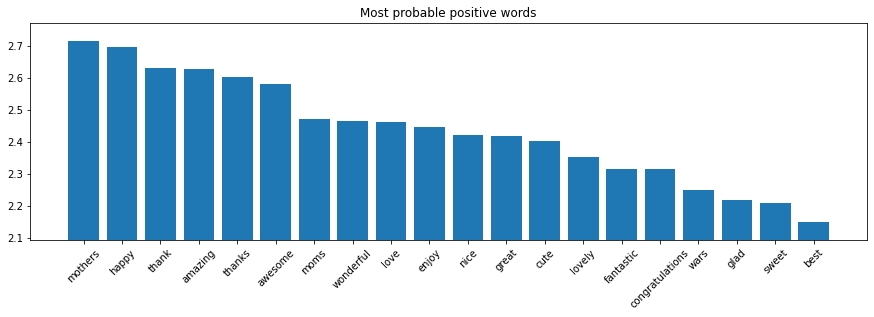

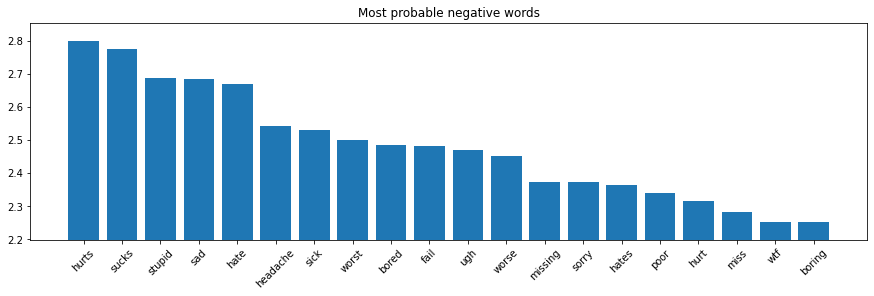

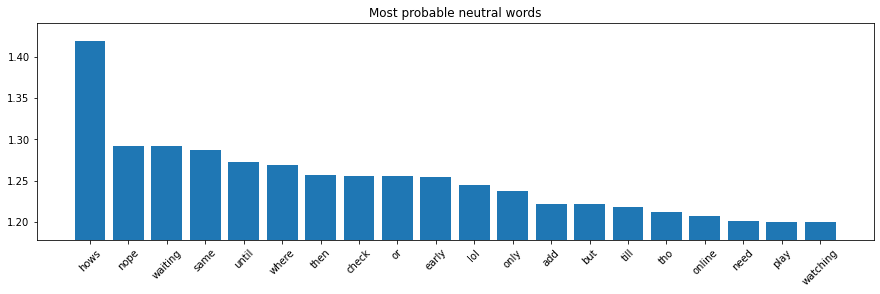

In [35]:
df_model = split_text(df_model, "text")
prior = {k: v for k, v in word_probas(df_model, "text").collect()}
for sentiment in ["positive", "negative", "neutral"]:
    plot_most_probable(df_model.filter(col("sentiment") == sentiment), "text", prior=prior,
                       title=f"Most probable {sentiment} words")

### Trump and Biden tweets (test) datasets

we now use an approach of constructing the prior dict of all datasets axcept the one we're calculating the probs on
- this discards very rare words present only in one dataset (uninteresting) and foreign (non-english) words
- all other approaches show completely useless results of misspelling, errors, etc, its hard to find differences between Trump and Biden at the word's level :D

In [32]:
df_trump = split_text(df_trump, "tweet")
df_biden = split_text(df_biden, "tweet")

In [33]:
print("Trump file count:", df_trump.count())
print("Biden file count:", df_biden.count())

Trump file count: 897161
Biden file count: 706477


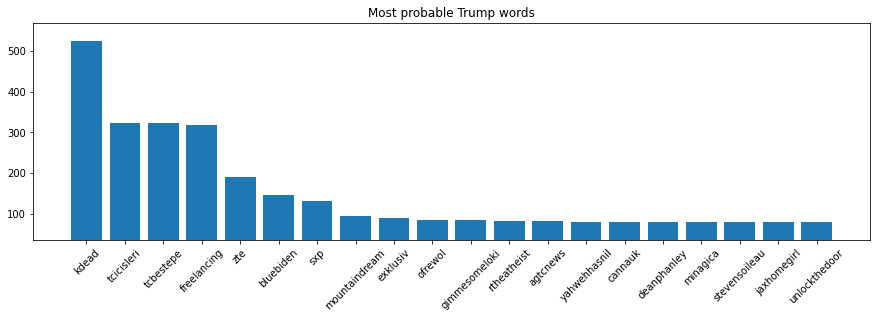

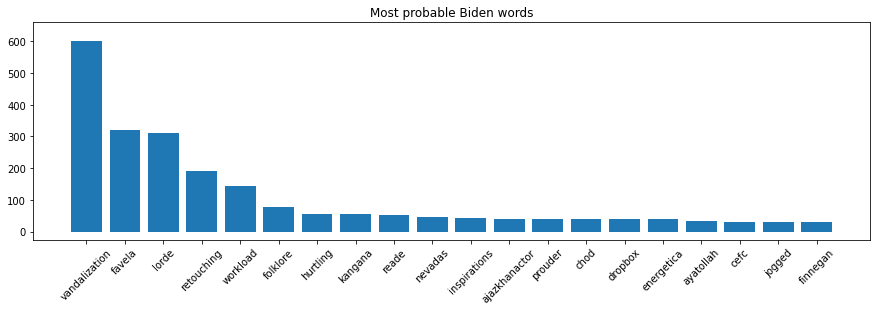

In [36]:
wc_tr = word_probas(df_biden.select(col("tweet")).union(df_model.select(col("text").alias("tweet"))), "tweet").collect()
prior = {k: v for k, v in wc_tr}
plot_most_probable(df_trump, "tweet", prior=prior, title=f"Most probable Trump words")

wc_bi = word_probas(df_trump.select(col("tweet")).union(df_model.select(col("text").alias("tweet"))), "tweet").collect()
prior = {k: v for k, v in wc_bi}
plot_most_probable(df_biden, "tweet", prior=prior, title=f"Most probable Biden words")

as the results are ambigous, we perform simple frequency analysis with stopwords removal in unioned Trum-Biden datasets to reveal words that are specific for the electional tweets in general

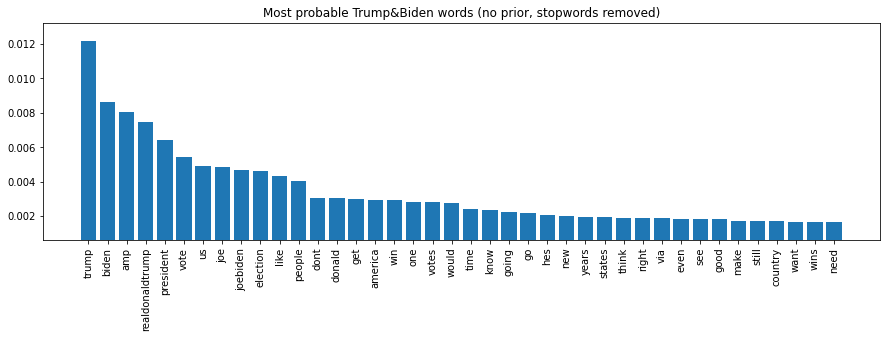

In [12]:
df_tr_bi = word_remove(df_biden.union(df_trump).select('tweet'),'tweet')
plot_most_probable(df_tr_bi, "text_", n=40, title=f"Most probable Trump&Biden words (no prior, stopwords removed)", rot = 90)

### Wordclouds

In [65]:
#wordclouds with stopwords

In [ ]:
wordcounts_trump = word_probas(df_trump, 'tweet').collect()
wordcounts_biden = word_probas(df_biden, 'tweet').collect()
wordcounts_model = word_probas(df_model, 'text').collect()

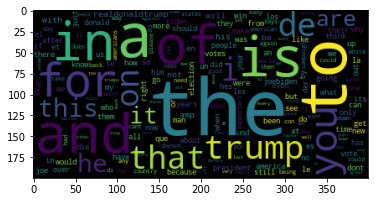

In [16]:
wordcloud(wordcounts_trump)

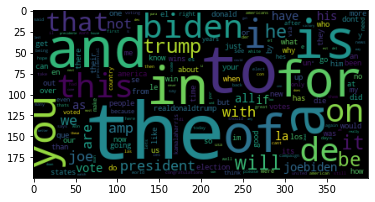

In [17]:
wordcloud(wordcounts_biden)

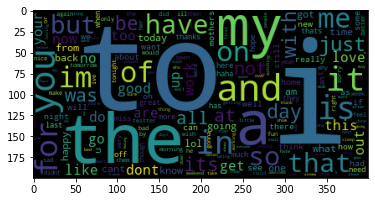

In [18]:
wordcloud(wordcounts_model)

In [23]:
#wordclouds without stopwords

In [11]:
wordcounts_trump = word_probas(word_remove(df_trump, 'tweet'),'text_').collect()
wordcounts_biden = word_probas(word_remove(df_biden, 'tweet'),'text_').collect()
wordcounts_model = word_probas(word_remove(df_model, 'text'),'text_').collect()

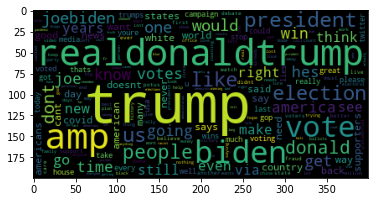

In [15]:
wordcloud(wordcounts_trump)

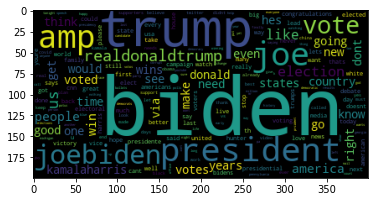

In [13]:
wordcloud(wordcounts_biden)

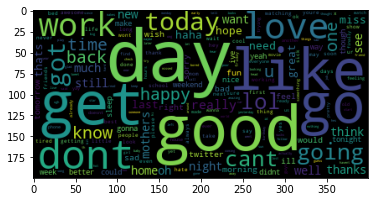

In [14]:
wordcloud(wordcounts_model)